# **Recover momentum broadenings from correlators of color or invariant Lorentz forces**

## Default simulation parameters for the Glasma and the Wong solvers

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 1024    
tau_sim = 5.0     
DTS = 2     

# Glasma
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0           

# Wong
mass = 10**3
tau_form = 0  
pT = 0    
ntp = 10**5  
nevents = 3    
representation = 'fundamental'      
boundary = 'periodic'       

## Set environment variables and import all relevant modules

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
from curraun.wong import init_mom_toy, init_pos, init_charge

import curraun.kappa_wong as kappa_wong
import curraun.kappa as kappa

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

Using CUDA
Using SU(3)
Using double precision
Using double precision


# Momentum broadenings from `kappa_wong.py`
Computes momentum broadening similarly as in `kappa.py` but with Lorentz forces along the trajectories. This is done either with color or invariant Lorentz forces computed in `wong.py`

In [3]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(ev): 
    output = {}

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', pT / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    # Momentum broadening from the Wong solver
    mom_broad_wong = np.zeros((maxt-formt, 4))

    # Initialize the Kappa module
    kappa_tforce = kappa.TransportedForce(s)
    mom_broad_kappa, tau_kappa =  [], []

    kappa_wong_tforce = kappa_wong.TransportedForce(s, wong_solver, ntp)
    mom_broad_kappa_wong_fc, mom_broad_kappa_wong_finv =  [], []

    if use_cuda:
        kappa_tforce.copy_to_device()
        kappa_wong_tforce.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Solve Wong's equations
            if t>=formt:  
                # Compute momentum broadening from Wong solver
                mom_broad_wong[t-formt] = wong_solver.p_sq_mean * E0**2

                wong_solver.evolve()
                wong_solver.compute_mom_broad()

                # Compute momentum broadening from Kappa module
                if t % DTS == 0:
                    if use_cuda:
                        kappa_tforce.copy_mean_to_host()
                        kappa_wong_tforce.copy_mean_to_host()

                    mom_broad_kappa.append(kappa_tforce.p_perp_mean * E0 ** 2)
                    tau_kappa.append(t*a/DTS)

                    mom_broad_kappa_wong_fc.append(kappa_wong_tforce.p_perp_mean_fc * E0 ** 2)
                    mom_broad_kappa_wong_finv.append(kappa_wong_tforce.p_perp_mean_finv * E0 ** 2)
                    
                    if use_cuda:
                        kappa_tforce.copy_mean_to_device()
                        kappa_wong_tforce.copy_mean_to_device()

                kappa_tforce.compute()
                kappa_wong_tforce.compute(wong_solver)

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output["mom_broad_wong"] = mom_broad_wong
    output["mom_broad_kappa"], output["tau_kappa"] = mom_broad_kappa, tau_kappa
    output["mom_broad_kappa_wong_fc"], output["mom_broad_kappa_wong_finv"] = mom_broad_kappa_wong_fc, mom_broad_kappa_wong_finv

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return output

## Running the Wong solver over multiple Glasma events

In [4]:
mom_broads_wong, mom_broads_kappa = [], []
mom_broads_kappa_wong_fc, mom_broads_kappa_wong_finv = [], []

for ev in range(nevents):
    output = simulate(ev)
    mom_broads_wong.append(output["mom_broad_wong"])
    mom_broads_kappa.append(np.array(output["mom_broad_kappa"]))
    mom_broads_kappa_wong_fc.append(np.array(output["mom_broad_kappa_wong_fc"]))
    mom_broads_kappa_wong_finv.append(np.array(output["mom_broad_kappa_wong_finv"]))

mom_broad_wong, mom_broad_kappa = np.mean(mom_broads_wong, axis=0), np.mean(mom_broads_kappa, axis=0)
mom_broad_wong = np.mean(mom_broads_wong, axis=0)
mom_broad_kappa_wong_fc, mom_broad_kappa_wong_finv = np.mean(mom_broads_kappa_wong_fc, axis=0), np.mean(mom_broads_kappa_wong_finv, axis=0)

formt, maxt = int(tau_form / L * N * DTS), int(tau_sim / L * N * DTS)
tau_wong = np.linspace(tau_form, tau_sim, maxt-formt)
tau_kappa = np.array(output["tau_kappa"])

output = {}
output["mom_broad_wong"], output["tau_wong"] = mom_broad_wong, tau_wong
output["mom_broad_kappa"], output["tau_kappa"] = mom_broad_kappa, tau_kappa
output["mom_broad_kappa_wong_fc"], output["mom_broad_kappa_wong_finv"] = mom_broad_kappa_wong_fc, mom_broad_kappa_wong_finv
output["Qs"], output["hbarc"] = Qs, hbarc

filename = 'wong_vs_kappa_wong.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle) 

Event 3: 100%|██████████| 1024/1024 [51:04<00:00,  2.99s/it]


## Read data from file using Julia

In [2]:
using Pickle

output = Pickle.npyload("results/wong_vs_kappa_wong.pickle")
mom_broad_wong, tau_wong = output["mom_broad_wong"], output["tau_wong"]
mom_broad_kappa, tau_kappa = output["mom_broad_kappa"], output["tau_kappa"]
mom_broad_kappa_wong_fc, mom_broad_kappa_wong_finv = output["mom_broad_kappa_wong_fc"], output["mom_broad_kappa_wong_finv"]
Qs, hbarc = output["Qs"], output["hbarc"]

(2, 0.197326)

## Plot momentum broadenings, using Makie from Julia

In [3]:
function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

string_as_varname (generic function with 1 method)

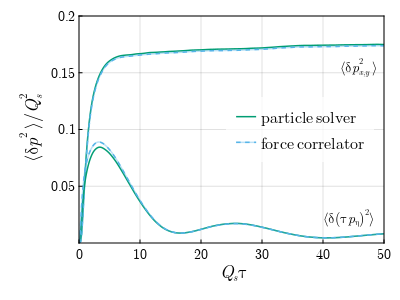

CairoScreen{Cairo.CairoSurfaceIOStream{UInt32}} with surface:
Cairo.CairoSurfaceIOStream{UInt32}(Ptr{Nothing} @0x00000000082302d0, 300.0, 225.0, IOContext(IOStream(<file /home/dana/curraun/notebooks/plots/recover_mom_broad_force_corr.pdf>)))


In [4]:
using CairoMakie
using ColorSchemes

custom_colors = ["#9300d3", "#019d73", "#57b5e8"]
colors = [custom_colors[1], custom_colors[2], custom_colors[3]]
width_line = 1.5

fig = Figure(resolution = (400, 300), font = "CMU Serif")
ax = Axis(fig[1, 1], 
        xlabel=L"Q_s\tau", ylabel=L"\langle \delta p^2\,\rangle/ Q_s^2",
        xlabelsize = 18, ylabelsize= 18, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=4, ytickalign=1, yticksize=4,  xlabelpadding = -5, )

# dimenstion of fundamental representation for SU(3)
DR = 3

tags = ["x", "eta"]
linestyles = [nothing, :dash, :dashdot]
for (i, j) in enumerate([1, 3])
        if j==3
                mb_wong = mom_broad_wong[:, j+1]
        else
                mb_wong = mom_broad_wong[:, j]
        end
        mb_kappa_wong_fc = mom_broad_kappa_wong_fc[:, j]
        mb_kappa_wong_finv = mom_broad_kappa_wong_finv[:, j]


        string_as_varname("wong_"*tags[i], lines!(ax, tau_wong*Qs/hbarc, mb_wong/Qs^2/DR, linewidth = width_line, color=colors[2]))
        string_as_varname("kappa_wong_fc_dash_"*tags[i], lines!(ax, tau_kappa*Qs/hbarc, mb_kappa_wong_fc/Qs^2/DR, linewidth = width_line, color=colors[3], linestyle=:dash))
        string_as_varname("kappa_wong_fc_transp_"*tags[i], lines!(ax, tau_kappa*Qs/hbarc, mb_kappa_wong_fc/Qs^2/DR, linewidth = width_line, color=(colors[3], 0.4)))
        # string_as_varname("kappa_wong_finv_"*tags[i], lines!(ax, tau_kappa*Qs/hbarc, mb_kappa_wong_finv/Qs^2, linewidth = 1.5, color=colors[3]))
end

ylims!(ax, 0, 0.2)
xlims!(ax, 0, 50)
yticks = [0.05, 0.1, 0.15, 0.2]
ax.yticks = (yticks, string.(yticks))

legend = [L"\mathrm{particle\,solver}", L"\mathrm{force\,correlator}"]
axislegend(ax, [wong_x, [kappa_wong_fc_dash_x, kappa_wong_fc_transp_x]], legend, labelsize=16, position = :rc, orientation = :vertical, bgcolor = (:white, 0.7), framecolor=(:grey80, 0))

text!(ax, L"\langle \delta p_{x,y}^2 \,\rangle", position = (43, 0.146), textsize=14)
text!(ax, L"\langle \delta (\tau p_\eta)^2 \rangle", position = (40.2, 0.014), textsize=14)


display(fig)
save("plots/recover_mom_broad_force_corr.png", fig, px_per_unit=5.0) 
save("plots/recover_mom_broad_force_corr.pdf", fig) 